<a href="https://colab.research.google.com/github/massidi/TPLSTM_NLP/blob/main/sentimental_analysis2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Load Tweet dataset***
Loading data from my local file ,source( [kaggel](https://www.kaggle.com/datasets/kazanova/sentiment140))



In [ ]:
!pip install tensorflow==2.15


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [ ]:
pip install --upgrade nltk



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import tensorflow as tf

from keras.layers import Embedding
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.preprocessing.text import one_hot
from keras.layers import LSTM
from keras.layers import Dense,Bidirectional

import numpy as np
import pandas as pd


import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
import re






from sklearn.model_selection import train_test_split

tf.get_logger().setLevel('ERROR')


In [ ]:
# # detect and init the TPU
# tpu = tf.distribute.cluster_resolver.TPUClusterResolver()

# # instantiate a distribution strategy
# tf.tpu.experimental.initialize_tpu_system(tpu)
# tpu_strategy = tf.distribute.TPUStrategy(tpu)

In [ ]:



import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv
/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv


In [ ]:
train_tweets = pd.read_csv('/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv',names=['id', 'User', 'target','text'])
test_tweets  = pd.read_csv('/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv',names=['id', 'User', 'target','text'])


In [ ]:
train_tweets.head(5)

,id,User,target,text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [ ]:
test_tweets.head(5)

,id,User,target,text
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


# ***Data pre-processing***

### This code cell performs data preprocessing on the train_tweets DataFrame:



1.   It prints the shape of the DataFrame.
2.   It prints the count of null values in each column of the DataFrame
3.   It drops rows with null values from the DataFrame.
4.   It prints the shape of the DataFrame after dropping null values.







In [ ]:
print("shape of train_data:" ,train_tweets.shape)
print("count the nul value:" ,train_tweets.isnull().sum())

print("---------------\n")
print("shape of train_data:" ,test_tweets.shape)
print("count the nul value:" ,test_tweets.isnull().sum())





shape of train_data: (74682, 4)
count the nul value: id          0
User        0
target      0
text      686
dtype: int64
---------------

shape of train_data: (1000, 4)
count the nul value: id        0
User      0
target    0
text      0
dtype: int64


In [ ]:
train_tweets=train_tweets.dropna()
print("after dropping a null value from train data :", train_tweets.shape)
print("--------------------------")
print(train_tweets['target'].value_counts())

after dropping a null value from train data : (73996, 4)
--------------------------
target
Negative      22358
Positive      20655
Neutral       18108
Irrelevant    12875
Name: count, dtype: int64



# *Data Preprocessing and Label Refinement for Sentiment Analysis*
1. This cell renames the 'target' column to 'label' in the train_tweets DataFrame,
2. drops irrelevant rows with the 'Irrelevant' label,
3. and creates a new DataFrame train_messages with relevant messages for analysis.


In [ ]:
train_tweets = train_tweets.rename(columns={'target': 'label'})
test_tweets = test_tweets.rename(columns={'target': 'label'})


# Drop irrelevant rows
def drop_irrelevant(df):
    return df[~df['label'].str.contains('Irrelevant')]

# Apply drop_irrelevant function

train_messages = drop_irrelevant(train_tweets.drop(['id', 'User'], axis=1))
test_messages = drop_irrelevant(test_tweets.drop(['id', 'User'], axis=1))

# train_messages = train_tweets.drop(['id', 'b'], axis=1)
# test_messages = test_tweets.drop(['id', 'b'], axis=1)



In [ ]:
display(train_messages.shape)

display(test_messages.shape)

(61121, 2)

(828, 2)

# Transforming Labels to Numerical Values

*In this cell, we define a mapping dictionary to convert textual labels into numerical values for sentiment analysis. The label_mapping dictionary assigns numerical values (-1 for 'Negative', 0 for 'Neutral', and 1 for 'Positive') to corresponding textual labels. Then, we use the map() function to apply this mapping to the 'label' column in the DataFrame train_messages, effectively transforming textual labels into numerical values. Finally, we display the DataFrame to verify the transformation*.






In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

train_label= None

# Map labels to numerical values
train_messages['label'] = label_encoder.fit_transform(train_messages["label"])
test_messages['label'] = label_encoder.fit_transform(test_messages['label'])

# print(train_messages)


train_label = train_messages.drop(['text'], axis=1)
test_label = test_messages.drop(['text'], axis=1)


In [ ]:
# Display the DataFrame with numerical labels
# display(train_messages.shape)
# print("------------------\n")

# display(test_messages.shape)

In [ ]:
# Display the DataFrame with numerical labels
# display(train_messages)
# print("------------------\n")
# display(test_messages)

In [ ]:

print("train data to count the numer record in each label :", train_label.value_counts())

print("test data to count the numer record in each label :", test_label.value_counts())


train data to count the numer record in each label : label
0        22358
2        20655
1        18108
Name: count, dtype: int64
test data to count the numer record in each label : label
1        285
2        277
0        266
Name: count, dtype: int64


In [ ]:
m_train = train_messages.copy()
m_train.reset_index(inplace=True)

m_test = test_messages.copy()
m_test.reset_index(inplace=True)

In [ ]:
m_train.shape,m_test.shape

((61121, 3), (828, 3))

### ***providing a quick overview of the distribution of sentiment labels in the dataset.***

In [ ]:
# import matplotlib.pyplot as plt
# print(plt.get_backend())


In [ ]:
#For data visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

%matplotlib inline

# pd.options.plotting.backend = "plotly"

<Axes: xlabel='label'>

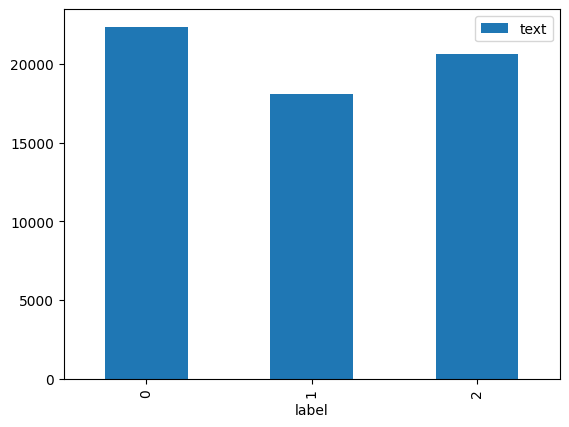

In [ ]:
import string as str

data_train = m_train[['text', 'label']].copy()
data_train.groupby('label').count().plot(kind='bar')


<Axes: xlabel='label'>

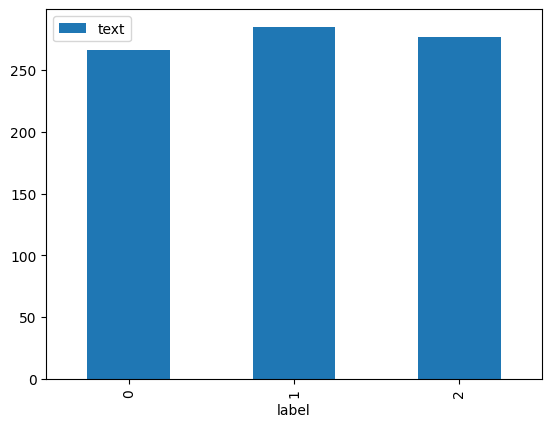

In [ ]:
data_test = m_test[['text', 'label']].copy()
data_test.groupby('label').count().plot(kind='bar')

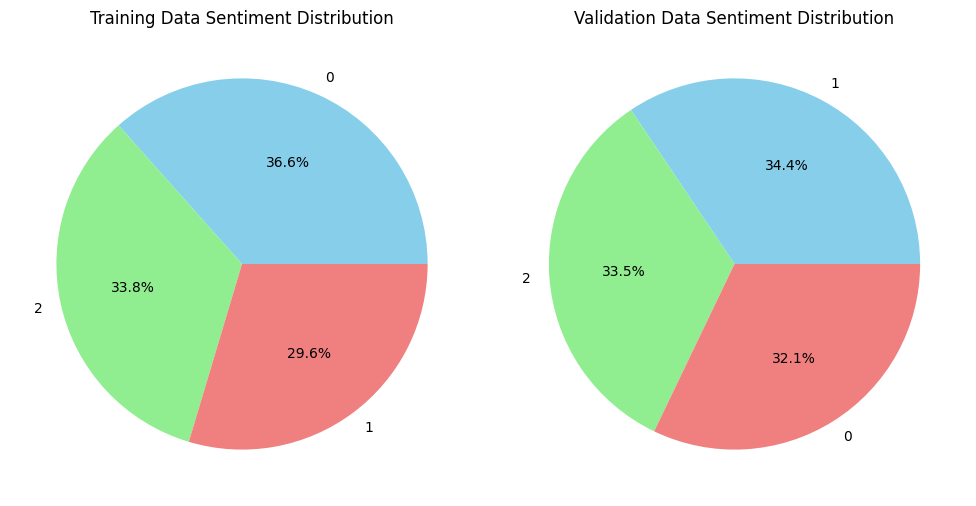

In [ ]:
# Calculate the number of sentiment labels in training data and validation data
train_sentiment_counts = data_train['label'].value_counts()
valid_sentiment_counts = data_test['label'].value_counts()

# Draw a pie chart for the training data
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.pie(train_sentiment_counts, labels=train_sentiment_counts.index, autopct='%1.1f%%', colors=['skyblue', 'lightgreen', 'lightcoral'])
plt.title('Training Data Sentiment Distribution')

# Draw a pie chart for the valid data
plt.subplot(1, 2, 2)
plt.pie(valid_sentiment_counts, labels=valid_sentiment_counts.index, autopct='%1.1f%%', colors=['skyblue', 'lightgreen', 'lightcoral'])

plt.title('Validation Data Sentiment Distribution')

plt.tight_layout()
plt.show()

*This code snippet uses NLTK and regular expressions to preprocess text data. It removes non-alphabetic characters, converts text to lowercase, and applies stemming while excluding stopwords. The resulting preprocessed text is stored in a list called `corpus`, facilitating further analysis such as sentiment analysis or topic modeling.*

In [ ]:

def clean_text(text):

    text = re.sub('\[.*?\]', '', text)
    # links
    text = re.sub('https?://\S+|www\.\S+', '', text)
    # multiple dots
    text = re.sub('<.*?>+', '', text)
    # punctuation
    text = re.sub('[%s]' % re.escape(str.punctuation), '', text)
    # new lines
    text = re.sub('\n', '', text)
    # words containing numbers
    text = re.sub('\w*\d\w*', '', text)
    # Remove any remaining non-ASCII characters
    text = ''.join(char for char in text if ord(char) < 128)
    return text

In [ ]:
from keras.preprocessing.text import Tokenizer


# Download NLTK resources

# nltk.download()
nltk.download('stopwords')
nltk.download('wordnet')

# nltk.data.path.append('/kaggle/working/')


class TextPreprocessor:
    def __init__(self):
        # Initialize lemmatizer and stemmer
        self.lemm = WordNetLemmatizer()
        self.stemmer = PorterStemmer()

        # Define stopwords including negation words
        self.stop_words = set(stopwords.words('english'))
        self.negation_words = {'not', 'no', 'never', 'nor'}
        self.stop_words -= self.negation_words

        # Initialize corpus
        self.corpus = []

    def normalized_text(self, data):
        """Preprocesses text data."""
        for i in range(len(data)):
#             review =  clean_text(data[i])
            review = re.sub('[^a-zA-Z]', ' ', data[i])
            review = review.lower()
            review = review.split()
            review = [self.lemm.lemmatize(word) for word in review if word not in self.stop_words]
            review = ' '.join(review)
            self.corpus.append(review)
        return self.corpus

    def preprocess_text(self, df, voc_size, sent_length):


        onehot_repr = [one_hot(words, voc_size) for words in df]
        embedded_docs = pad_sequences(onehot_repr, padding='pre', maxlen=sent_length)
        return embedded_docs

    def vectorized_text(self,df,voc_size,sent_length):

        tok = Tokenizer(voc_size)
        tok.fit_on_texts(df)
        sequences = tok.texts_to_sequences(df)
        sequences_matrix = pad_sequences(sequences,maxlen=sent_length)
        return sequences_matrix





[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
import nltk


train_data_preprocessor = TextPreprocessor()

df2 = train_data_preprocessor.normalized_text(data_train['text'])

print( pd.DataFrame({'text': df2}).shape)


(61121, 1)


In [ ]:
max_length = 0

# Iterate through each string in the list
for string in df2:

    words = string.split()

    for word in words:
        # Update maximum length if necessary
        max_length = max(max_length, len(word))


print("Maximum length of a word:", max_length)

Maximum length of a word: 396


In [ ]:
df2

['im getting borderland murder',
 'coming border kill',
 'im getting borderland kill',
 'im coming borderland murder',
 'im getting borderland murder',
 'im getting borderland murder',
 'spent hour making something fun know huge borderland fan maya one favorite character decided make wallpaper pc original image versus creation made enjoy pic twitter com mlsi wf jg',
 'spent couple hour something fun know huge borderland fan maya one favorite character decided make wallpaper pc original picture compared creation made fun pic twitter com mlsi wf jg',
 'spent hour something fun know huge borderland fan maya one favorite character',
 'spent hour making something fun know huge rhandlerr fan maya one favorite character decided make wallpaper pc original image versus creation made enjoy pic twitter com mlsi wf jg',
 'spent hour making something fun know huge rhandlerr fan maya one favorite character decided make wallpaper pc original image versus creation made enjoy pic twitter com mlsi wf jg

In [ ]:
# max_length=32

voc_size=5000

embedded_docs_train =train_data_preprocessor.preprocess_text(df2,voc_size,max_length)

print(embedded_docs_train)

# embedded_docs_train =train_data_preprocessor.vectorized_text(df2, voc_size, max_length)

# print(embedded_docs_train)




[[   0    0    0 ... 2543 2716  134]
 [   0    0    0 ... 3850 3476 2644]
 [   0    0    0 ... 2543 2716 2644]
 ...
 [   0    0    0 ... 1227 4210 2258]
 [   0    0    0 ... 4210 4545 2258]
 [   0    0    0 ... 1227 4210 2258]]


In [ ]:
test_data_preprocessor = TextPreprocessor()

df3 = test_data_preprocessor.normalized_text(data_test['text'])

print( pd.DataFrame({'text': df3}).shape)

(828, 1)


In [ ]:
embedded_docs_test = test_data_preprocessor.preprocess_text(df3,voc_size,max_length)

embedded_docs_test


array([[   0,    0,    0, ..., 4921, 3342, 2591],
       [   0,    0,    0, ..., 2765, 1396, 2467],
       [   0,    0,    0, ...,  586, 4473, 2410],
       ...,
       [   0,    0,    0, ...,  153, 2793,  627],
       [   0,    0,    0, ...,  854, 3011, 4042],
       [   0,    0,    0, ..., 4350, 1124, 3570]], dtype=int32)

In [ ]:
pd.DataFrame({'text': df3}).tail(10)

,text
818,suikoden alex kidd miracle world persona soul ...
819,thank matching fund home depot rw payment gene...
820,tom clancy rainbow six siege great game play n...
821,late night stream boy come watch warzone run s...
822,guess broke
823,please explain possible let company overcharge...
824,good sony much want see new p going right much...
825,today sucked time drink wine n play borderland...
826,bought fraction microsoft today small win
827,johnson johnson stop selling talc baby powder ...


*This code block defines a neural network model for text classification. It utilizes an embedding layer to transform input words into dense vectors, followed by a Bidirectional LSTM layer to capture contextual information bidirectionally. The model is then compiled with the sparse categorical cross-entropy loss function, the Adam optimizer, and accuracy as the evaluation metric. Finally, the model summary is printed, providing an overview of its architecture and the number of trainable parameters.*

In [ ]:
Embedding

keras.src.layers.core.embedding.Embedding

In [ ]:
# from keras.layers import Flatten
from keras.layers import Dropout as dropout

from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score


# y_pred3.history

# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()

# instantiate a distribution strategy
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

with tpu_strategy.scope():
## Creating model
    embedding_vector_features=20
    model=Sequential()

    model.add(Embedding(voc_size,embedding_vector_features,input_shape=(max_length,)))


    model.add(Bidirectional(LSTM(150, dropout=0.5, return_sequences= False)))

    model.add(Dense(200, activation='relu'))
    model.add(dropout(0.5))



    model.add(Dense(150, activation='relu'))

    model.add(dropout(0.5))





    model.add(Dense(3,activation='sigmoid'))



    model.compile(loss='sparse_categorical_crossentropy',optimizer='RMSprop',metrics=['accuracy'], jit_compile='False')


In [ ]:
 print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 396, 20)           100000    
                                                                 
 bidirectional (Bidirection  (None, 300)               205200    
 al)                                                             
                                                                 
 dense (Dense)               (None, 200)               60200     
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense_1 (Dense)             (None, 150)               30150     
                                                                 
 dropout_1 (Dropout)         (None, 150)               0         
                                                        

In [ ]:
x_train=np.array(embedded_docs_train)
y_train=np.array(data_train["label"])

x_train.shape,y_train.shape

((61121, 396), (61121,))

In [ ]:
x_validate =np.array(embedded_docs_test)
y_validate = np.array(data_test["label"])

x_validate.shape, y_validate.shape

((828, 396), (828,))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, random_state=20)

In [ ]:
print("X_train:",X_train.shape)
print("X_test:",X_test.shape)

X_train: (45840, 396)
X_test: (15281, 396)


In [ ]:
### Finally Training
# 10*tpu_strategy.num_replicas_in_sync

y_pred3 = model.fit(X_train,y_train,validation_data=(x_validate,y_validate),epochs=25,batch_size=10*tpu_strategy.num_replicas_in_sync )

Epoch 1/25


2024-04-11 23:18:38.350873: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-04-11 23:18:38.374084: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-04-11 23:18:38.397799: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-04-11 23:18:38.420232: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-04-11 23:18:38.442909: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-04-11 23:18:38.466515: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-04-11 23:18:38.489175: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this 

  7/573 [..............................] - ETA: 13s - loss: 1.0923 - accuracy: 0.3946 

2024-04-11 23:18:43.383220: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-04-11 23:18:43.386553: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-04-11 23:18:43.386729: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-04-11 23:18:43.386908: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-04-11 23:18:43.387113: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-04-11 23:18:43.387481: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-04-11 23:18:43.387706: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this 

571/573 [============================>.] - ETA: 0s - loss: 1.0016 - accuracy: 0.4883

2024-04-11 23:18:58.522594: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-04-11 23:18:58.522962: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-04-11 23:18:58.523373: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-04-11 23:18:58.523740: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-04-11 23:18:59.371469: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-04-11 23:18:59.371735: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-04-11 23:18:59.372328: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this 

573/573 [==============================] - 21s 29ms/step - loss: 1.0013 - accuracy: 0.4888 - val_loss: 0.8070 - val_accuracy: 0.6599
Epoch 2/25
573/573 [==============================] - 14s 24ms/step - loss: 0.7982 - accuracy: 0.6646 - val_loss: 0.6575 - val_accuracy: 0.7368
Epoch 3/25


2024-04-11 23:19:13.751884: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


573/573 [==============================] - 14s 24ms/step - loss: 0.7204 - accuracy: 0.7069 - val_loss: 0.6260 - val_accuracy: 0.7716
Epoch 4/25
  1/573 [..............................] - ETA: 14s - loss: 0.7199 - accuracy: 0.7250

2024-04-11 23:19:27.679181: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


573/573 [==============================] - 14s 24ms/step - loss: 0.7049 - accuracy: 0.7189 - val_loss: 0.6082 - val_accuracy: 0.7704
Epoch 5/25


2024-04-11 23:19:41.536752: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


573/573 [==============================] - 14s 24ms/step - loss: 0.6379 - accuracy: 0.7460 - val_loss: 0.5516 - val_accuracy: 0.7909
Epoch 6/25


2024-04-11 23:19:55.420432: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


573/573 [==============================] - 14s 24ms/step - loss: 0.6290 - accuracy: 0.7530 - val_loss: 0.8104 - val_accuracy: 0.6238
Epoch 7/25
573/573 [==============================] - 14s 24ms/step - loss: 0.5944 - accuracy: 0.7636 - val_loss: 0.4969 - val_accuracy: 0.8125
Epoch 8/25
573/573 [==============================] - 14s 24ms/step - loss: 0.5677 - accuracy: 0.7771 - val_loss: 0.4919 - val_accuracy: 0.8281
Epoch 9/25


2024-04-11 23:20:36.999033: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


573/573 [==============================] - 14s 24ms/step - loss: 0.5449 - accuracy: 0.7844 - val_loss: 0.4608 - val_accuracy: 0.8486
Epoch 10/25


2024-04-11 23:20:50.963182: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


573/573 [==============================] - 14s 24ms/step - loss: 0.5304 - accuracy: 0.7919 - val_loss: 0.4755 - val_accuracy: 0.8401
Epoch 11/25
573/573 [==============================] - 14s 24ms/step - loss: 0.5172 - accuracy: 0.7967 - val_loss: 0.4549 - val_accuracy: 0.8678
Epoch 12/25
573/573 [==============================] - 14s 24ms/step - loss: 0.5046 - accuracy: 0.8023 - val_loss: 0.4272 - val_accuracy: 0.8594
Epoch 13/25
  1/573 [..............................] - ETA: 13s - loss: 0.6003 - accuracy: 0.7250

2024-04-11 23:21:32.697509: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


573/573 [==============================] - 14s 24ms/step - loss: 0.4959 - accuracy: 0.8073 - val_loss: 0.4166 - val_accuracy: 0.8726


2024-04-11 23:21:46.536833: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


Epoch 14/25
573/573 [==============================] - 14s 24ms/step - loss: 0.4784 - accuracy: 0.8127 - val_loss: 0.4201 - val_accuracy: 0.8654
Epoch 15/25
573/573 [==============================] - 14s 24ms/step - loss: 0.4741 - accuracy: 0.8146 - val_loss: 0.4025 - val_accuracy: 0.8726
Epoch 16/25
573/573 [==============================] - 14s 24ms/step - loss: 0.4654 - accuracy: 0.8190 - val_loss: 0.4089 - val_accuracy: 0.8702
Epoch 17/25
573/573 [==============================] - 14s 24ms/step - loss: 0.4599 - accuracy: 0.8209 - val_loss: 0.4137 - val_accuracy: 0.8702
Epoch 18/25
573/573 [==============================] - 14s 24ms/step - loss: 0.4513 - accuracy: 0.8257 - val_loss: 0.3844 - val_accuracy: 0.8798
Epoch 19/25
573/573 [==============================] - 14s 24ms/step - loss: 0.4436 - accuracy: 0.8277 - val_loss: 0.3735 - val_accuracy: 0.8798
Epoch 20/25
573/573 [==============================] - 14s 24ms/step - loss: 0.4356 - accuracy: 0.8305 - val_loss: 0.3926 - val_ac

In [ ]:
y_predict = model.predict(X_test)
y_predict




2024-04-11 23:24:35.330200: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.


478/478 [==============================] - 7s 11ms/step


array([[2.5490820e-03, 8.2610846e-03, 5.3688705e-02],
       [1.9354820e-03, 6.6766143e-04, 2.9108644e-02],
       [5.6242943e-04, 1.7881393e-07, 8.9406967e-08],
       ...,
       [2.7359456e-01, 2.2240937e-01, 3.2243124e-01],
       [2.7359456e-01, 2.2240937e-01, 3.2243124e-01],
       [2.7359456e-01, 2.2240937e-01, 3.2243124e-01]], dtype=float32)

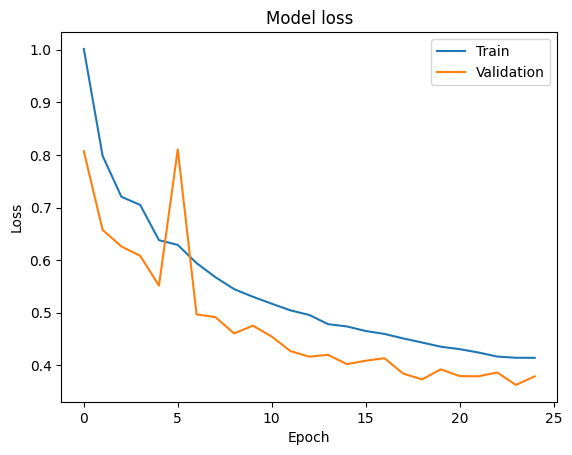

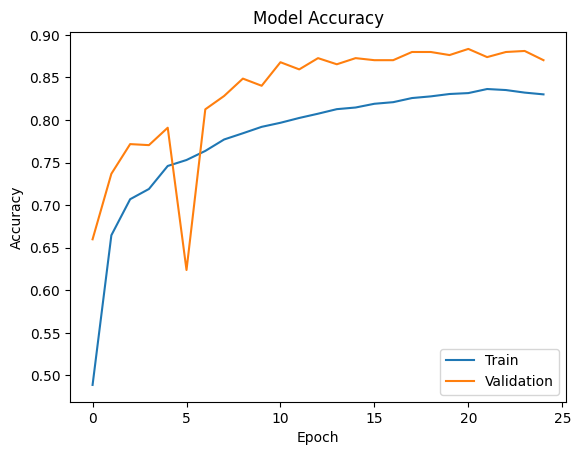

In [ ]:
plt.plot(y_pred3.history['loss'])
plt.plot(y_pred3.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


# Plot the accuracy of training and validation
plt.plot(y_pred3.history['accuracy'])
plt.plot(y_pred3.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [ ]:
# Save the trained model
model.save('sentimentaltp1.h5')


/usr/local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from keras.preprocessing.sequence import pad_sequences
import numpy as np

label = {3: 'Positive', 2: 'Neutral', 1: 'Negative'}

text_to_predict = None
preprocessed_text = None
embedded_text = None
predicted_probabilities = None
text_to_predict =["i love you so much","i dont't,like you i will murder you" ,"you are a good man God blesse you","im getting on borderlands 2 and i will murder","i dont't,like you i will murder you","i dont't,like you i will murder you"]




# Normalize the text
preprocessed_text = test_data_preprocessor.normalized_text(text_to_predict)

# Convert the preprocessed text into embedded form
embedded_text = test_data_preprocessor.preprocess_text(preprocessed_text, voc_size, max_length)

# Use the trained LSTM model to predict the sentiment
predicted_probabilities = model.predict (embedded_text)

# Convert probabilities to sentiment labels
for i in range(min(len(predicted_probabilities), len(text_to_predict))):
    predicted_label = np.argmax(predicted_probabilities[i])

#     if predicted_label == 0:
#         print("Sentence: ", text_to_predict[i])
#         print("number: ", predicted_label)
#         print("numerical label:", label[0])
#         print("----------------------------")
    if predicted_label == 1:
        print("number: ", predicted_label)
        print("Sentence: ", text_to_predict[i])
        print("numerical label:", label[1])
        print("----------------------------")
    elif predicted_label == 2:
        print("Sentence: ", text_to_predict[i])
        print("number: ", predicted_label)
        print("numerical label:", label[2])
        print("----------------------------")
    elif predicted_label == 3:
        print("Sentence: ", text_to_predict[i])
        print("number: ", predicted_label)
        print("numerical label:", label[3])
        print("----------------------------")




In [ ]:
max_length

In [ ]:
model.predict

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


In [ ]:
tf.saved_model

In [ ]:
# model.save('')
tf.saved_model.save(model,'sentimentalAnalysistp')